In [199]:
import torch
from lxml import etree
from tqdm import tqdm
import os
from pyvis.network import Network
import numpy as np
from dataclasses import dataclass
import pandas as pd

In [166]:
BASE_DIR = "/run/media/nikita/e40c1d03-27f0-4c5f-b778-1710c9a842d0/data/server_sync/data/v6/"
print(len(os.listdir(BASE_DIR)))

97


In [167]:
TEST_FOLDER = os.path.join(BASE_DIR, '0')

In [168]:
geom_xml = etree.parse(os.path.join(TEST_FOLDER, 'geometry.xml')).getroot()
mats_xml = etree.parse(os.path.join(TEST_FOLDER, 'materials.xml')).getroot()
geom_xml, mats_xml

(<Element geometry at 0x760d28d1cd00>, <Element materials at 0x760d28d1edc0>)

In [169]:
for mat in mats_xml:
    print(mat.tag, mat.keys(), mat.values())
    for item in mat:
        print(item.tag, item.keys(), item.values())

material ['id', 'name', 'volume'] ['1', 'Water', '155.4871681372756']
density ['units', 'value'] ['g/cm3', '1']
nuclide ['ao', 'name'] ['1.99968852', 'H1']
nuclide ['ao', 'name'] ['0.00031148', 'H2']
nuclide ['ao', 'name'] ['0.999621', 'O16']
nuclide ['ao', 'name'] ['0.000379', 'O17']
material ['depletable', 'id', 'name', 'volume'] ['true', '2', 'Fuel', '298.45130209103024']
density ['units', 'value'] ['g/cm3', '8.3']
nuclide ['ao', 'name'] ['1.999242', 'O16']
nuclide ['ao', 'name'] ['0.000758', 'O17']
nuclide ['ao', 'name'] ['0.0004523305496957069', 'U234']
nuclide ['ao', 'name'] ['0.05060678291113409', 'U235']
nuclide ['ao', 'name'] ['0.00023180337298067612', 'U236']
nuclide ['ao', 'name'] ['0.9487090831661896', 'U238']
material ['id', 'name', 'volume'] ['5', 'Zircaloy-2', '537.2123437638545']
density ['units', 'value'] ['g/cm3', '6.56']
nuclide ['ao', 'name'] ['0.006794423937', 'O16']
nuclide ['ao', 'name'] ['2.576063e-06', 'O17']
nuclide ['ao', 'name'] ['7.568990000000001e-05', 'Cr

In [170]:
for el in geom_xml:
    print(el.tag, el.keys(), el.values())

cell ['id', 'material', 'region', 'universe'] ['1', '2', '-1 10 -9', '2']
cell ['id', 'material', 'region', 'universe'] ['2', '5', '1 -2 10 -9', '2']
cell ['id', 'material', 'region', 'universe'] ['3', '1', '2 -3 4 -5 -8 6 7 10 -9', '2']
surface ['coeffs', 'id', 'type'] ['0.0 0.0 0.49999999999999994', '1', 'z-cylinder']
surface ['coeffs', 'id', 'type'] ['0.0 0.0 0.7', '2', 'z-cylinder']
surface ['boundary', 'coeffs', 'id', 'type'] ['reflective', '0.7499999999999999', '3', 'y-plane']
surface ['boundary', 'coeffs', 'id', 'type'] ['reflective', '-0.7499999999999999', '4', 'y-plane']
surface ['boundary', 'coeffs', 'id', 'type'] ['reflective', '1.7320508075688772 1.0 0.0 1.4999999999999998', '5', 'plane']
surface ['boundary', 'coeffs', 'id', 'type'] ['reflective', '-1.7320508075688772 1.0 0.0 -1.4999999999999998', '6', 'plane']
surface ['boundary', 'coeffs', 'id', 'type'] ['reflective', '1.7320508075688772 1.0 0.0 -1.4999999999999998', '7', 'plane']
surface ['boundary', 'coeffs', 'id', 'typ

In [171]:
mats, cells, surfs = {}, {}, {}
for mat in mats_xml:
    # print(mat.tag, mat.keys(), mat.values())
    _el = {
            key:value for key,value in zip(mat.keys(), mat.values()) if key!='id' 
        } | {'nuclides':[], 'density':0}
    for item in mat:
        if item.tag == 'density':
            _el['density']=item.get('value')
        elif item.tag=='nuclide':
            _el['nuclides'].append(item.values())    
    mats[mat.get('id')] = _el
for el in geom_xml:
    # print(el.tag, el.keys(), el.values())
    _el = {
            key:value for key,value in zip(el.keys(), el.values()) if key!='id' 
        }
    if el.tag == 'cell':
        cells[el.get('id')]=_el
    else:
        surfs[el.get('id')]=_el

mats, cells, surfs

({'1': {'name': 'Water',
   'volume': '155.4871681372756',
   'nuclides': [['1.99968852', 'H1'],
    ['0.00031148', 'H2'],
    ['0.999621', 'O16'],
    ['0.000379', 'O17']],
   'density': '1'},
  '2': {'depletable': 'true',
   'name': 'Fuel',
   'volume': '298.45130209103024',
   'nuclides': [['1.999242', 'O16'],
    ['0.000758', 'O17'],
    ['0.0004523305496957069', 'U234'],
    ['0.05060678291113409', 'U235'],
    ['0.00023180337298067612', 'U236'],
    ['0.9487090831661896', 'U238']],
   'density': '8.3'},
  '5': {'name': 'Zircaloy-2',
   'volume': '537.2123437638545',
   'nuclides': [['0.006794423937', 'O16'],
    ['2.576063e-06', 'O17'],
    ['7.568990000000001e-05', 'Cr50'],
    ['0.0014596043800000002', 'Cr52'],
    ['0.00016550742', 'Cr53'],
    ['4.11983e-05', 'Cr54'],
    ['9.48059e-05', 'Fe54'],
    ['0.00148824988', 'Fe56'],
    ['3.437018e-05', 'Fe57'],
    ['4.57404e-06', 'Fe58'],
    ['0.0005255536679999999', 'Ni58'],
    ['0.000202442332', 'Ni60'],
    ['8.800028e-06', 

In [172]:
nodes = []
labels = []
for mat_id, mat in mats.items():
    nodes.append(f'material_{mat_id}')
    labels.append(f"{mat['name']} (material)")

for cell_id, cell in cells.items():
    nodes.append(f'cell_{cell_id}')
    labels.append(mats[cell['material']]['name'] + " cell")

for surf_id, surf in surfs.items():
    nodes.append(f'surf_{surf_id}')
    labels.append(surf['type'])

nodes, labels

(['material_1',
  'material_2',
  'material_5',
  'cell_1',
  'cell_2',
  'cell_3',
  'surf_1',
  'surf_2',
  'surf_3',
  'surf_4',
  'surf_5',
  'surf_6',
  'surf_7',
  'surf_8',
  'surf_9',
  'surf_10'],
 ['Water (material)',
  'Fuel (material)',
  'Zircaloy-2 (material)',
  'Fuel cell',
  'Zircaloy-2 cell',
  'Water cell',
  'z-cylinder',
  'z-cylinder',
  'y-plane',
  'y-plane',
  'plane',
  'plane',
  'plane',
  'plane',
  'z-plane',
  'z-plane'])

In [173]:
edges = []
for cell_id, cell_desc in cells.items():
    print(cell_desc)
    edges.append((f'cell_{cell_id}', f'material_{cell_desc["material"]}'))
    for surf in cell_desc["region"].replace('-', '').split(' '):
        edges.append((f'cell_{cell_id}', f'surf_{surf}'))
edges

{'material': '2', 'region': '-1 10 -9', 'universe': '2'}
{'material': '5', 'region': '1 -2 10 -9', 'universe': '2'}
{'material': '1', 'region': '2 -3 4 -5 -8 6 7 10 -9', 'universe': '2'}


[('cell_1', 'material_2'),
 ('cell_1', 'surf_1'),
 ('cell_1', 'surf_10'),
 ('cell_1', 'surf_9'),
 ('cell_2', 'material_5'),
 ('cell_2', 'surf_1'),
 ('cell_2', 'surf_2'),
 ('cell_2', 'surf_10'),
 ('cell_2', 'surf_9'),
 ('cell_3', 'material_1'),
 ('cell_3', 'surf_2'),
 ('cell_3', 'surf_3'),
 ('cell_3', 'surf_4'),
 ('cell_3', 'surf_5'),
 ('cell_3', 'surf_8'),
 ('cell_3', 'surf_6'),
 ('cell_3', 'surf_7'),
 ('cell_3', 'surf_10'),
 ('cell_3', 'surf_9')]

In [174]:
net = Network(notebook = True, cdn_resources = "remote",
                height = "750px",
                width = "100%",
)
net.add_nodes(
    nodes, 
    label=labels, 
    color=['#00ff1e']*3+['#162347']*3 +  ['#dd4b39']*10
)
net.add_edges(edges)
net.show('graph.html')

graph.html


In [175]:
@dataclass
class NeutronicGraphNode:
    node_type:str
    node_data:list
    node_name:str
    node_id:int

In [176]:
mats, cells, surfs

({'1': {'name': 'Water',
   'volume': '155.4871681372756',
   'nuclides': [['1.99968852', 'H1'],
    ['0.00031148', 'H2'],
    ['0.999621', 'O16'],
    ['0.000379', 'O17']],
   'density': '1'},
  '2': {'depletable': 'true',
   'name': 'Fuel',
   'volume': '298.45130209103024',
   'nuclides': [['1.999242', 'O16'],
    ['0.000758', 'O17'],
    ['0.0004523305496957069', 'U234'],
    ['0.05060678291113409', 'U235'],
    ['0.00023180337298067612', 'U236'],
    ['0.9487090831661896', 'U238']],
   'density': '8.3'},
  '5': {'name': 'Zircaloy-2',
   'volume': '537.2123437638545',
   'nuclides': [['0.006794423937', 'O16'],
    ['2.576063e-06', 'O17'],
    ['7.568990000000001e-05', 'Cr50'],
    ['0.0014596043800000002', 'Cr52'],
    ['0.00016550742', 'Cr53'],
    ['4.11983e-05', 'Cr54'],
    ['9.48059e-05', 'Fe54'],
    ['0.00148824988', 'Fe56'],
    ['3.437018e-05', 'Fe57'],
    ['4.57404e-06', 'Fe58'],
    ['0.0005255536679999999', 'Ni58'],
    ['0.000202442332', 'Ni60'],
    ['8.800028e-06', 

In [177]:
from utils.general import get_atom_num

nucliedes = []
for mat in mats.values():
    for num, nuc in mat['nuclides']:
        nucliedes.append(nuc)
nucliedes = list(set(nucliedes))
nucliedes = sorted(nucliedes, key=get_atom_num)
len(nucliedes)

36

In [178]:
nucliedes

['H1',
 'H2',
 'O16',
 'O17',
 'Cr50',
 'Cr52',
 'Cr53',
 'Cr54',
 'Fe54',
 'Fe56',
 'Fe57',
 'Ni58',
 'Fe58',
 'Ni60',
 'Ni61',
 'Ni62',
 'Ni64',
 'Zr90',
 'Zr91',
 'Zr92',
 'Zr94',
 'Zr96',
 'Sn112',
 'Sn114',
 'Sn115',
 'Sn116',
 'Sn117',
 'Sn118',
 'Sn119',
 'Sn120',
 'Sn122',
 'Sn124',
 'U234',
 'U235',
 'U236',
 'U238']

In [179]:
neutro_nodes = []
for mat_id, mat_data in mats.items():
    _type = 'material'
    name = mat_data.pop('name')

    isos = mat_data.pop('nuclides')
    iso_dict = {key:0 for key in nucliedes}
    for iso_val, iso_name in isos:
        iso_dict[iso_name]=float(iso_val)
    
    node_data = [iso_dict, mat_data]

    print(node_data)
    node = NeutronicGraphNode(
        node_type = _type,
        node_data = node_data,
        node_name = name,
        node_id = int(mat_id)
    )
    print(node)
    neutro_nodes.append(node)

[{'H1': 1.99968852, 'H2': 0.00031148, 'O16': 0.999621, 'O17': 0.000379, 'Cr50': 0, 'Cr52': 0, 'Cr53': 0, 'Cr54': 0, 'Fe54': 0, 'Fe56': 0, 'Fe57': 0, 'Ni58': 0, 'Fe58': 0, 'Ni60': 0, 'Ni61': 0, 'Ni62': 0, 'Ni64': 0, 'Zr90': 0, 'Zr91': 0, 'Zr92': 0, 'Zr94': 0, 'Zr96': 0, 'Sn112': 0, 'Sn114': 0, 'Sn115': 0, 'Sn116': 0, 'Sn117': 0, 'Sn118': 0, 'Sn119': 0, 'Sn120': 0, 'Sn122': 0, 'Sn124': 0, 'U234': 0, 'U235': 0, 'U236': 0, 'U238': 0}, {'volume': '155.4871681372756', 'density': '1'}]
NeutronicGraphNode(node_type='material', node_data=[{'H1': 1.99968852, 'H2': 0.00031148, 'O16': 0.999621, 'O17': 0.000379, 'Cr50': 0, 'Cr52': 0, 'Cr53': 0, 'Cr54': 0, 'Fe54': 0, 'Fe56': 0, 'Fe57': 0, 'Ni58': 0, 'Fe58': 0, 'Ni60': 0, 'Ni61': 0, 'Ni62': 0, 'Ni64': 0, 'Zr90': 0, 'Zr91': 0, 'Zr92': 0, 'Zr94': 0, 'Zr96': 0, 'Sn112': 0, 'Sn114': 0, 'Sn115': 0, 'Sn116': 0, 'Sn117': 0, 'Sn118': 0, 'Sn119': 0, 'Sn120': 0, 'Sn122': 0, 'Sn124': 0, 'U234': 0, 'U235': 0, 'U236': 0, 'U238': 0}, {'volume': '155.4871681372756'

In [180]:
for surface_id, surface_data in surfs.items():
    print(surface_data)
    _type = "surface"
    if surface_data['type'] in ['z-cylinder', 'plane'] :
        surf_data = surface_data['coeffs'].split()
    elif surface_data['type'] == 'x-plane':
        surf_data = [1, 0, 0, float(surface_data['coeffs'])]
    elif surface_data['type'] == 'y-plane':
        surf_data = [0, 1, 0, float(surface_data['coeffs'])]
    elif surface_data['type'] == 'z-plane':
        surf_data = [0, 0, 1, float(surface_data['coeffs'])]

    node = NeutronicGraphNode(
        node_type = _type,
        node_data = surf_data,
        node_name = surface_data['type'],
        node_id = int(surface_id)
    )
    print(node)
    neutro_nodes.append(node)
neutro_nodes

{'coeffs': '0.0 0.0 0.49999999999999994', 'type': 'z-cylinder'}
NeutronicGraphNode(node_type='surface', node_data=['0.0', '0.0', '0.49999999999999994'], node_name='z-cylinder', node_id=1)
{'coeffs': '0.0 0.0 0.7', 'type': 'z-cylinder'}
NeutronicGraphNode(node_type='surface', node_data=['0.0', '0.0', '0.7'], node_name='z-cylinder', node_id=2)
{'boundary': 'reflective', 'coeffs': '0.7499999999999999', 'type': 'y-plane'}
NeutronicGraphNode(node_type='surface', node_data=[0, 1, 0, 0.7499999999999999], node_name='y-plane', node_id=3)
{'boundary': 'reflective', 'coeffs': '-0.7499999999999999', 'type': 'y-plane'}
NeutronicGraphNode(node_type='surface', node_data=[0, 1, 0, -0.7499999999999999], node_name='y-plane', node_id=4)
{'boundary': 'reflective', 'coeffs': '1.7320508075688772 1.0 0.0 1.4999999999999998', 'type': 'plane'}
NeutronicGraphNode(node_type='surface', node_data=['1.7320508075688772', '1.0', '0.0', '1.4999999999999998'], node_name='plane', node_id=5)
{'boundary': 'reflective', 'c

[NeutronicGraphNode(node_type='material', node_data=[{'H1': 1.99968852, 'H2': 0.00031148, 'O16': 0.999621, 'O17': 0.000379, 'Cr50': 0, 'Cr52': 0, 'Cr53': 0, 'Cr54': 0, 'Fe54': 0, 'Fe56': 0, 'Fe57': 0, 'Ni58': 0, 'Fe58': 0, 'Ni60': 0, 'Ni61': 0, 'Ni62': 0, 'Ni64': 0, 'Zr90': 0, 'Zr91': 0, 'Zr92': 0, 'Zr94': 0, 'Zr96': 0, 'Sn112': 0, 'Sn114': 0, 'Sn115': 0, 'Sn116': 0, 'Sn117': 0, 'Sn118': 0, 'Sn119': 0, 'Sn120': 0, 'Sn122': 0, 'Sn124': 0, 'U234': 0, 'U235': 0, 'U236': 0, 'U238': 0}, {'volume': '155.4871681372756', 'density': '1'}], node_name='Water', node_id=1),
 NeutronicGraphNode(node_type='material', node_data=[{'H1': 0, 'H2': 0, 'O16': 1.999242, 'O17': 0.000758, 'Cr50': 0, 'Cr52': 0, 'Cr53': 0, 'Cr54': 0, 'Fe54': 0, 'Fe56': 0, 'Fe57': 0, 'Ni58': 0, 'Fe58': 0, 'Ni60': 0, 'Ni61': 0, 'Ni62': 0, 'Ni64': 0, 'Zr90': 0, 'Zr91': 0, 'Zr92': 0, 'Zr94': 0, 'Zr96': 0, 'Sn112': 0, 'Sn114': 0, 'Sn115': 0, 'Sn116': 0, 'Sn117': 0, 'Sn118': 0, 'Sn119': 0, 'Sn120': 0, 'Sn122': 0, 'Sn124': 0, 'U234': 

In [181]:
for cell_id, cell_data in cells.items():
    print(cell_data)
    _type = 'cell'
    _data = {
        'material': int(cell_data['material']),
        'surfs':[int(x) for x in cell_data['region'].replace('-', '').split(' ')]
    }
    node = NeutronicGraphNode(
        node_type = _type,
        node_data = [_data],
        node_name = f"Cell {cell_id}",
        node_id = int(cell_id)
    )
    print(node)
    neutro_nodes.append(node)
neutro_nodes

{'material': '2', 'region': '-1 10 -9', 'universe': '2'}
NeutronicGraphNode(node_type='cell', node_data=[{'material': 2, 'surfs': [1, 10, 9]}], node_name='Cell 1', node_id=1)
{'material': '5', 'region': '1 -2 10 -9', 'universe': '2'}
NeutronicGraphNode(node_type='cell', node_data=[{'material': 5, 'surfs': [1, 2, 10, 9]}], node_name='Cell 2', node_id=2)
{'material': '1', 'region': '2 -3 4 -5 -8 6 7 10 -9', 'universe': '2'}
NeutronicGraphNode(node_type='cell', node_data=[{'material': 1, 'surfs': [2, 3, 4, 5, 8, 6, 7, 10, 9]}], node_name='Cell 3', node_id=3)


[NeutronicGraphNode(node_type='material', node_data=[{'H1': 1.99968852, 'H2': 0.00031148, 'O16': 0.999621, 'O17': 0.000379, 'Cr50': 0, 'Cr52': 0, 'Cr53': 0, 'Cr54': 0, 'Fe54': 0, 'Fe56': 0, 'Fe57': 0, 'Ni58': 0, 'Fe58': 0, 'Ni60': 0, 'Ni61': 0, 'Ni62': 0, 'Ni64': 0, 'Zr90': 0, 'Zr91': 0, 'Zr92': 0, 'Zr94': 0, 'Zr96': 0, 'Sn112': 0, 'Sn114': 0, 'Sn115': 0, 'Sn116': 0, 'Sn117': 0, 'Sn118': 0, 'Sn119': 0, 'Sn120': 0, 'Sn122': 0, 'Sn124': 0, 'U234': 0, 'U235': 0, 'U236': 0, 'U238': 0}, {'volume': '155.4871681372756', 'density': '1'}], node_name='Water', node_id=1),
 NeutronicGraphNode(node_type='material', node_data=[{'H1': 0, 'H2': 0, 'O16': 1.999242, 'O17': 0.000758, 'Cr50': 0, 'Cr52': 0, 'Cr53': 0, 'Cr54': 0, 'Fe54': 0, 'Fe56': 0, 'Fe57': 0, 'Ni58': 0, 'Fe58': 0, 'Ni60': 0, 'Ni61': 0, 'Ni62': 0, 'Ni64': 0, 'Zr90': 0, 'Zr91': 0, 'Zr92': 0, 'Zr94': 0, 'Zr96': 0, 'Sn112': 0, 'Sn114': 0, 'Sn115': 0, 'Sn116': 0, 'Sn117': 0, 'Sn118': 0, 'Sn119': 0, 'Sn120': 0, 'Sn122': 0, 'Sn124': 0, 'U234': 

In [192]:
with open('graph_nucliedes.txt', 'w') as f:
    f.write('\n'.join(nucliedes))

In [182]:
net = Network(notebook = True, cdn_resources = "remote")

nodes = []
colors = []
labels = []
edges = []
for node in neutro_nodes:
    if node.node_type == 'material':
        nodes.append(f"material_{node.node_id}")
        colors.append('#00ff1e')
        labels.append(node.node_name)
    elif node.node_type == 'surface':
        nodes.append(f"surface_{node.node_id}")
        colors.append('#162347')
        labels.append(node.node_name)
    elif node.node_type =='cell':
        node_data = node.node_data[0]
        mat_id = node_data['material']
        for surf_id in node_data['surfs']:
            edges.append((f"material_{mat_id}", f"surface_{surf_id}"))


net.add_nodes(
    nodes, 
    label=labels,
    color=colors
)
net.add_edges(edges)
net.show('graph_clean.html')

graph_clean.html


In [183]:
class MatSurfGraph():
    materials:dict=None
    planes:dict=None
    cylinders:dict=None
    edges:list=None
    isotopes:tuple = None
    
    def __init__(self, nodes:list[NeutronicGraphNode], isotopes:tuple=None):

        if self.isotopes is None:
            self.isotopes = isotopes
        assert self.isotopes is not None

        self.materials = {}
        self.cylinders = {}
        self.planes = {}
        pre_edges = []
        for node in nodes:
            if node.node_type == 'material':                
                mat_comp = {x:0 for x in self.isotopes}
                isos, vol_dens = node.node_data
                for nuc_name, nuc_count in isos.items():
                    mat_comp[nuc_name]=float(nuc_count)
                volume = float(vol_dens.get('volume'))
                density = float(vol_dens.get('density'))
                data = list(mat_comp.values())+[volume, density]
                self.materials[str(node.node_id)]=data
            elif node.node_type == 'surface':
                data = [float(x) for x in node.node_data]
                if 'plane' in node.node_name:
                    self.planes[str(node.node_id)]=data
                elif 'cylinder' in node.node_name:
                    self.cylinders[str(node.node_id)]=data
            elif node.node_type =='cell':
                node_data = node.node_data[0]
                mat_id = node_data['material']
                for surf_id in node_data['surfs']:
                    pre_edges.append((mat_id, surf_id))
        
        self.edges = self._convert_edges(pre_edges=pre_edges)
    
    def _convert_edges(self, pre_edges:list[tuple[int, int]])->list:
        edges = []
        num_mats = len(self.materials)
        mat_ids = self.all_node_ids[:num_mats]
        surf_ids = self.all_node_ids[num_mats:]
        for mat, surf in pre_edges:
            mat_ind = mat_ids.index(str(mat))
            surf_ind = num_mats + surf_ids.index(str(surf))
            edges.append((mat_ind, surf_ind))
            edges.append((surf_ind, mat_ind))

        return edges            


    
    @property
    def all_nodes(self) -> list:
        return list(self.materials.values()) + list(self.cylinders.values()) + list(self.planes.values())
    
    @property
    def all_node_ids(self) -> list:
        return list(self.materials.keys()) + list(self.cylinders.keys()) + list(self.planes.keys())


g = MatSurfGraph(neutro_nodes, isotopes=nucliedes)
g.all_nodes  

[[1.99968852,
  0.00031148,
  0.999621,
  0.000379,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  155.4871681372756,
  1.0],
 [0.0,
  0.0,
  1.999242,
  0.000758,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0004523305496957069,
  0.05060678291113409,
  0.00023180337298067612,
  0.9487090831661896,
  298.45130209103024,
  8.3],
 [0.0,
  0.0,
  0.006794423937,
  2.576063e-06,
  7.568990000000001e-05,
  0.0014596043800000002,
  0.00016550742,
  4.11983e-05,
  9.48059e-05,
  0.00148824988,
  3.437018e-05,
  0.0005255536679999999,
  4.57404e-06,
  0.000202442332,
  8.800028e-06,
  2.805834e-05,
  7.145632000000001e-06,
  0.5033765099999999,
  0.109774236,
  0.1

In [197]:
def load_graph(
    directory:str=TEST_FOLDER, 
    materials_filename:str='materials.xml',
    geometry_filename:str='geometry.xml',
    nucliedes:list|str=None
    ) -> MatSurfGraph:
    if nucliedes is None:
        nucliedes = 'graph_nucliedes.txt'
    if isinstance(nucliedes, str):
        with open(nucliedes, 'r') as f:
            nucliedes = f.read().split()
    print(nucliedes)
    geom_xml = etree.parse(os.path.join(directory, 'geometry.xml')).getroot()
    mats_xml = etree.parse(os.path.join(directory, 'materials.xml')).getroot()

    mats, cells, surfs = {}, {}, {}
    for mat in mats_xml:
        # print(mat.tag, mat.keys(), mat.values())
        _el = {
                key:value for key,value in zip(mat.keys(), mat.values()) if key!='id' 
            } | {'nuclides':[], 'density':0}
        for item in mat:
            if item.tag == 'density':
                _el['density']=item.get('value')
            elif item.tag=='nuclide':
                _el['nuclides'].append(item.values())    
        mats[mat.get('id')] = _el
    for el in geom_xml:
        # print(el.tag, el.keys(), el.values())
        _el = {
                key:value for key,value in zip(el.keys(), el.values()) if key!='id' 
            }
        if el.tag == 'cell':
            cells[el.get('id')]=_el
        else:
            surfs[el.get('id')]=_el

    neutro_nodes = []
    for mat_id, mat_data in mats.items():
        _type = 'material'
        name = mat_data.pop('name')

        isos = mat_data.pop('nuclides')
        iso_dict = {key:0 for key in nucliedes}
        for iso_val, iso_name in isos:
            iso_dict[iso_name]=float(iso_val)
        
        node_data = [iso_dict, mat_data]

        print(node_data)
        node = NeutronicGraphNode(
            node_type = _type,
            node_data = node_data,
            node_name = name,
            node_id = int(mat_id)
        )
        print(node)
        neutro_nodes.append(node)
    for surface_id, surface_data in surfs.items():
        print(surface_data)
        _type = "surface"
        if surface_data['type'] in ['z-cylinder', 'plane'] :
            surf_data = surface_data['coeffs'].split()
        elif surface_data['type'] == 'x-plane':
            surf_data = [1, 0, 0, float(surface_data['coeffs'])]
        elif surface_data['type'] == 'y-plane':
            surf_data = [0, 1, 0, float(surface_data['coeffs'])]
        elif surface_data['type'] == 'z-plane':
            surf_data = [0, 0, 1, float(surface_data['coeffs'])]

        node = NeutronicGraphNode(
            node_type = _type,
            node_data = surf_data,
            node_name = surface_data['type'],
            node_id = int(surface_id)
        )
        print(node)
        neutro_nodes.append(node)
    for cell_id, cell_data in cells.items():
        print(cell_data)
        _type = 'cell'
        _data = {
            'material': int(cell_data['material']),
            'surfs':[int(x) for x in cell_data['region'].replace('-', '').split(' ')]
        }
        node = NeutronicGraphNode(
            node_type = _type,
            node_data = [_data],
            node_name = f"Cell {cell_id}",
            node_id = int(cell_id)
        )
        print(node)
        neutro_nodes.append(node)
    return MatSurfGraph(neutro_nodes, isotopes=nucliedes)

In [198]:
load_graph(os.path.join(BASE_DIR, '1'))

['H1', 'H2', 'O16', 'O17', 'Cr50', 'Cr52', 'Cr53', 'Cr54', 'Fe54', 'Fe56', 'Fe57', 'Ni58', 'Fe58', 'Ni60', 'Ni61', 'Ni62', 'Ni64', 'Zr90', 'Zr91', 'Zr92', 'Zr94', 'Zr96', 'Sn112', 'Sn114', 'Sn115', 'Sn116', 'Sn117', 'Sn118', 'Sn119', 'Sn120', 'Sn122', 'Sn124', 'U234', 'U235', 'U236', 'U238']
[{'H1': 1.99968852, 'H2': 0.00031148, 'O16': 0.999621, 'O17': 0.000379, 'Cr50': 0, 'Cr52': 0, 'Cr53': 0, 'Cr54': 0, 'Fe54': 0, 'Fe56': 0, 'Fe57': 0, 'Ni58': 0, 'Fe58': 0, 'Ni60': 0, 'Ni61': 0, 'Ni62': 0, 'Ni64': 0, 'Zr90': 0, 'Zr91': 0, 'Zr92': 0, 'Zr94': 0, 'Zr96': 0, 'Sn112': 0, 'Sn114': 0, 'Sn115': 0, 'Sn116': 0, 'Sn117': 0, 'Sn118': 0, 'Sn119': 0, 'Sn120': 0, 'Sn122': 0, 'Sn124': 0, 'U234': 0, 'U235': 0, 'U236': 0, 'U238': 0}, {'volume': '155.4871681372756', 'density': '1'}]
NeutronicGraphNode(node_type='material', node_data=[{'H1': 1.99968852, 'H2': 0.00031148, 'O16': 0.999621, 'O17': 0.000379, 'Cr50': 0, 'Cr52': 0, 'Cr53': 0, 'Cr54': 0, 'Fe54': 0, 'Fe56': 0, 'Fe57': 0, 'Ni58': 0, 'Fe58': 0, '

In [207]:
def load_res(resultfilepath:str):
    results = pd.read_csv(resultfilepath, index_col=0)
    return results.k_inf.values[-1]-1
load_res(os.path.join(BASE_DIR, '1', 'data.csv'))

np.float64(0.22650270314961785)

In [208]:
def load_pair(
    basedir:str = BASE_DIR,
    folder:str = '0',
    results_filename:str = 'data.csv',
    materials_filename:str='materials.xml',
    geometry_filename:str='geometry.xml',
    nucliedes:list|str=None
) -> tuple[MatSurfGraph, float]:
    return load_graph(
        directory=os.path.join(basedir, folder),
        materials_filename = materials_filename,
        geometry_filename = geometry_filename,
        nucliedes = nucliedes
    ), load_res(
        os.path.join(basedir, folder, results_filename)
    )
load_pair()

['H1', 'H2', 'O16', 'O17', 'Cr50', 'Cr52', 'Cr53', 'Cr54', 'Fe54', 'Fe56', 'Fe57', 'Ni58', 'Fe58', 'Ni60', 'Ni61', 'Ni62', 'Ni64', 'Zr90', 'Zr91', 'Zr92', 'Zr94', 'Zr96', 'Sn112', 'Sn114', 'Sn115', 'Sn116', 'Sn117', 'Sn118', 'Sn119', 'Sn120', 'Sn122', 'Sn124', 'U234', 'U235', 'U236', 'U238']
[{'H1': 1.99968852, 'H2': 0.00031148, 'O16': 0.999621, 'O17': 0.000379, 'Cr50': 0, 'Cr52': 0, 'Cr53': 0, 'Cr54': 0, 'Fe54': 0, 'Fe56': 0, 'Fe57': 0, 'Ni58': 0, 'Fe58': 0, 'Ni60': 0, 'Ni61': 0, 'Ni62': 0, 'Ni64': 0, 'Zr90': 0, 'Zr91': 0, 'Zr92': 0, 'Zr94': 0, 'Zr96': 0, 'Sn112': 0, 'Sn114': 0, 'Sn115': 0, 'Sn116': 0, 'Sn117': 0, 'Sn118': 0, 'Sn119': 0, 'Sn120': 0, 'Sn122': 0, 'Sn124': 0, 'U234': 0, 'U235': 0, 'U236': 0, 'U238': 0}, {'volume': '155.4871681372756', 'density': '1'}]
NeutronicGraphNode(node_type='material', node_data=[{'H1': 1.99968852, 'H2': 0.00031148, 'O16': 0.999621, 'O17': 0.000379, 'Cr50': 0, 'Cr52': 0, 'Cr53': 0, 'Cr54': 0, 'Fe54': 0, 'Fe56': 0, 'Fe57': 0, 'Ni58': 0, 'Fe58': 0, '

(<__main__.MatSurfGraph at 0x760d194ee890>, np.float64(0.2265027031496194))

# Results

In [285]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [286]:
RES_DIR = "/home/nikita/PycharmProjects/OpenMC/neuro/models/v6/gcn3"
len(os.listdir(RES_DIR))

256

In [288]:
def load_test_res(directory:str, basedir=RES_DIR, filename='test.json'):
    with open(os.path.join(basedir, directory, filename), 'r') as f:
        true, pred = json.load(f).values()
        return np.array(true), np.array(pred)

def describe(true, pred, thresh=0):
    dif = true - pred
    # dif[abs(dif)<thresh]=0
    dif[dif>1]=1
    dif[dif<-1]=-1
    mean_abs = abs(dif).mean()
    mean = dif.mean()
    max_abs = abs(dif).max()
    best = abs(dif).min()
    return {
        'best':best,
        'worst':max_abs,
        'mean_abs':mean_abs,
        'mean':mean
    }

def is_fully_trained(_dir, filename='train.json')->bool:
    try:
        with open(os.path.join(RES_DIR, _dir, 'train.json')) as f:
            train_loss = json.load(f)['train_loss']
            return len(train_loss)>=100
    except FileNotFoundError:
        return False

fully_trained_dirs = list(filter(is_fully_trained, os.listdir(RES_DIR)))
load_test_res(fully_trained_dirs[0]), describe(*load_test_res(fully_trained_dirs[0]))

((array([1.45500103, 0.31396889, 0.80351941, 0.40549552, 0.43796738,
         0.73135625, 1.2500612 , 0.54816681, 1.45500103, 0.40549552,
         0.43796738, 0.43796738, 0.80351941, 0.64581507, 1.45500103,
         0.95239635, 1.2500612 , 1.2500612 , 0.95239635]),
  array([0.55216786, 0.7728264 , 0.7012423 , 0.66547433, 1.06107944,
         0.98352277, 1.06746176, 0.71005282, 0.97850546, 0.74403724,
         0.89752403, 0.6660603 , 1.38694328, 0.90073279, 0.71675232,
         1.26343009, 0.96472916, 0.73842701, 0.7197257 ])),
 {'best': np.float64(0.10227711352005142),
  'worst': np.float64(0.9028331687870228),
  'mean_abs': np.float64(0.3875609694420895),
  'mean': np.float64(-0.02628824361753328)})

In [289]:
dims1, dims2 = [], []
for _dir in fully_trained_dirs:
    k, dim1, dim2 = _dir.split('_')[-3:]
    # k = int(k.replace('k', ''))
    dim1=dim1.replace('id', '')
    dims1.append(int(dim1)), dims2.append(int(dim2))
dims1 = sorted(list(set(dims1)))
dims2 = sorted(list(set(dims2)))
# ks = sorted(list(set(ks)))
dims1, dims2#, ks

([2, 4, 6, 8, 10, 12, 14, 16, 20, 24, 28, 32, 40, 48, 56, 64],
 [2, 4, 6, 8, 10, 12, 14, 16, 20, 24, 28, 32, 40, 48, 56, 64])

In [164]:
sq = [dims2.index(x) for x in dims1]
sq

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 19]

In [290]:
desc = np.zeros((4, len(dims1), len(dims2)))
K = 3
for _dir in fully_trained_dirs:
    k, dim1, dim2 = _dir.split('_')[-3:]
    dim1 = dim1.replace('id', '')
    # k = int(k.replace('k', ''))
    # if k !=K:
    #    continue
    x, y = dims1.index(int(dim1)), dims2.index(int(dim2))
    results = describe(*load_test_res(_dir), thresh=0.1)
    desc[:, x, y] = list(results.values())
best, worst, mean_abs, mean = desc
desc.shape

(4, 16, 16)

In [264]:
desc = desc[..., sq]
dims2 = dims1

IndexError: index 17 is out of bounds for axis 2 with size 16

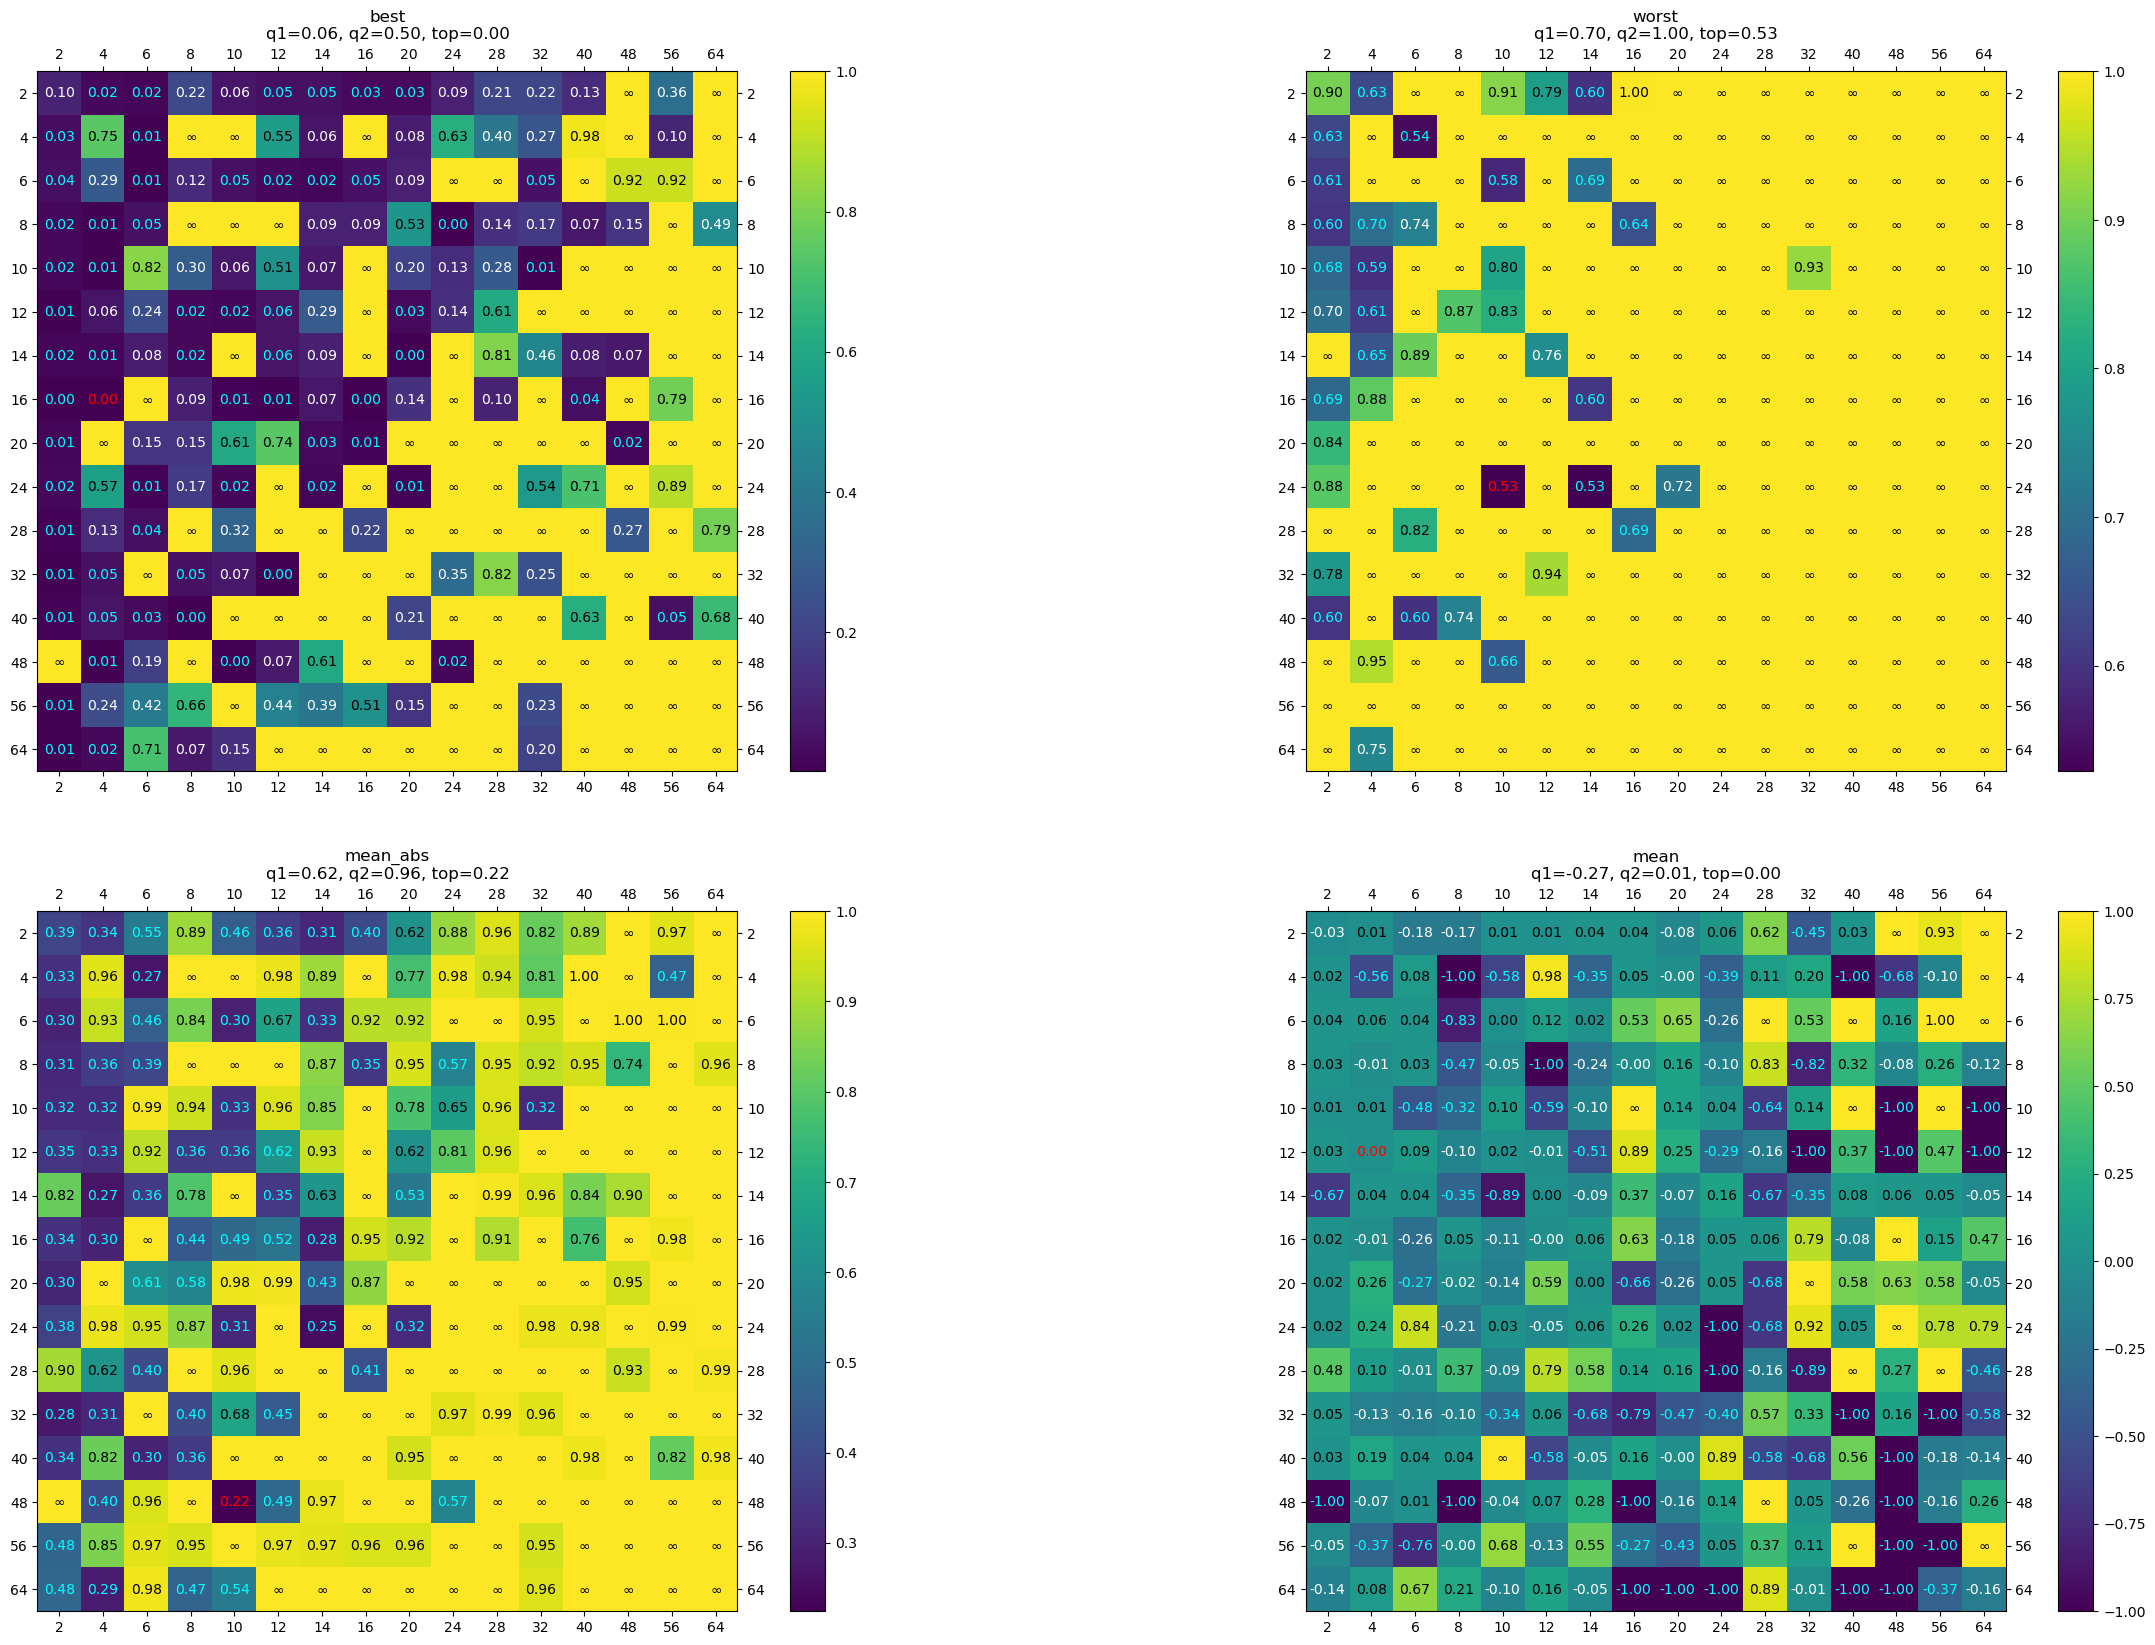

In [291]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(30,20))
for i, kind in enumerate(['best','worst','mean_abs','mean']):
    _max, _min = desc[i,...].max(), desc[i,...].min()
    q2 = np.median(desc[i,...])
    q1 = desc[i,...]
    q1 = q1[q1!=0]
    _amin = abs(q1).min()
    q1 = q1[q1<q2]    
    q1 = np.median(q1)
    _mean = (_max+_min)/2
    # q2, q1 = (_max+_min)/2, _min+(_max-_min)/4
    im = axes[i//2, i%2].imshow(desc[i,...])
    cbar = axes[i//2, i%2].figure.colorbar(im, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f"{kind}\n{q1=:.2f}, {q2=:.2f}, top={_amin:.2f}")
    for x, id1 in enumerate(dims1):
        for y, id2 in enumerate(dims2):
            val = desc[i, x, y]
            if val>=1:
                text = "$\\infty$"
                color = 'black'
            elif val ==0:
                text = '$\\varnothing$'
                color = 'w'
                continue
            else:
                text = f"{val:.2f}"
                if abs(val)==_amin:
                    color='r'
                elif val <= q1:
                    color='cyan'
                elif val < _mean:
                    color = 'w'
                else:
                    color = 'black'
            plt_text = axes[i//2, i%2].text(y,x, text,
                       ha="center", va="center", color=color)
    axes[i//2, i%2].set_yticks(range(len(dims1)), labels=dims1)
    axes[i//2, i%2].set_xticks(range(len(dims2)), labels=dims2, )
    axes[i//2, i%2].tick_params(top=True, bottom=True, left=True, right=True, labeltop=True, labelbottom=True, labelleft=True, labelright=True)
    

In [293]:
best = []
mean_best = []
for _dir in list(filter(is_fully_trained, os.listdir(RES_DIR))):
    results = describe(*load_test_res(_dir), thresh=0.1)
    best.append((_dir, float(results['worst'])))
    mean_best.append((_dir, float(results['mean_abs'])))

best.sort(key=lambda x: x[1])
mean_best.sort(key=lambda x: x[1])
best[:10], mean_best[:10]

([('power_gcn_id24_10', 0.5288491597595417),
  ('power_gcn_id24_14', 0.5307327261390886),
  ('power_gcn_id4_6', 0.5412674894752703),
  ('power_gcn_id6_10', 0.5805511227073872),
  ('power_gcn_id10_4', 0.5936142405691347),
  ('power_gcn_id2_14', 0.5973712107241183),
  ('power_gcn_id40_6', 0.5983965703542129),
  ('power_gcn_id40_2', 0.6000370024420182),
  ('power_gcn_id8_2', 0.6009985557022295),
  ('power_gcn_id16_14', 0.6049324771585665)],
 [('power_gcn_id48_10', 0.22411175577361053),
  ('power_gcn_id24_14', 0.24980680864824634),
  ('power_gcn_id14_4', 0.26572931034698377),
  ('power_gcn_id4_6', 0.2682102990982223),
  ('power_gcn_id32_2', 0.27852268597020263),
  ('power_gcn_id16_14', 0.28241771899568735),
  ('power_gcn_id64_4', 0.28546404133194),
  ('power_gcn_id6_10', 0.2952769138366806),
  ('power_gcn_id16_4', 0.29848209799692327),
  ('power_gcn_id40_6', 0.299327096031697)])

In [294]:
best = []
mean_best = []
for _dir in list(filter(is_fully_trained, os.listdir(RES_DIR))):
    results = describe(*load_test_res(_dir), thresh=0.0)
    best.append((_dir, float(results['worst'])))
    mean_best.append((_dir, float(results['mean_abs'])))

best.sort(key=lambda x: x[1])
mean_best.sort(key=lambda x: x[1])
best[:10], mean_best[:10]

([('power_gcn_id24_10', 0.5288491597595417),
  ('power_gcn_id24_14', 0.5307327261390886),
  ('power_gcn_id4_6', 0.5412674894752703),
  ('power_gcn_id6_10', 0.5805511227073872),
  ('power_gcn_id10_4', 0.5936142405691347),
  ('power_gcn_id2_14', 0.5973712107241183),
  ('power_gcn_id40_6', 0.5983965703542129),
  ('power_gcn_id40_2', 0.6000370024420182),
  ('power_gcn_id8_2', 0.6009985557022295),
  ('power_gcn_id16_14', 0.6049324771585665)],
 [('power_gcn_id48_10', 0.22411175577361053),
  ('power_gcn_id24_14', 0.24980680864824634),
  ('power_gcn_id14_4', 0.26572931034698377),
  ('power_gcn_id4_6', 0.2682102990982223),
  ('power_gcn_id32_2', 0.27852268597020263),
  ('power_gcn_id16_14', 0.28241771899568735),
  ('power_gcn_id64_4', 0.28546404133194),
  ('power_gcn_id6_10', 0.2952769138366806),
  ('power_gcn_id16_4', 0.29848209799692327),
  ('power_gcn_id40_6', 0.299327096031697)])

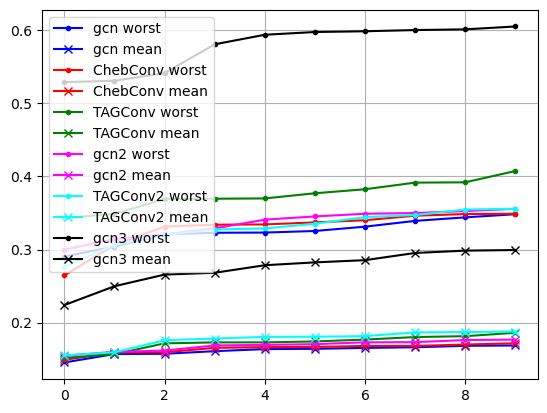

In [296]:
import json
try:
    with open('summary.json', 'r') as f:    
        summary = json.load(f)
except:
    summary = {}
finally:
    model_name = RES_DIR.split('/')[-1]
    summary[model_name] = {
        'top10':{
            'worst result': best[:10],
            'average result': mean_best[:10]
            }
        }
    with open('summary.json', 'w') as f:  
        json.dump(summary, f)
raw = {model:[] for model in summary.keys()}
for model_name, model_data in summary.items():
    w, a = model_data['top10'].values()
    resw = [x[-1] for x in list(w)]
    resa = [x[-1] for x in list(a)]
    raw[model_name] = (resw, resa)
fig, ax = plt.subplots()
colors = ['blue', 'red', 'green', 'magenta', 'cyan', 'black']
i=0
for model, res in raw.items():
    ax.grid(True)
    c = colors[i]
    i+=1
    ax.plot(res[0], label=f'{model} worst', marker='.', c=c)
    ax.plot(res[1], label=f'{model} mean', marker='x', c=c)
ax.legend()